In [ ]:
# Instalando ambiente anaconda
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
# Instalando pacote pyscipopt para uso do SCIP
!conda install pyscipopt

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [ ]:
# ambiente para o SCIP

#import shutil

# Especificando os caminhos originais e de destino
#orig_lib_path = '/usr/local/lib/libscip.so.8.1'
#dest_lib_path = '/usr/local/lib/libscip.so.8.0'

#orig_versioned_lib_path = '/usr/local/lib/libscip.so.8.1.0.0'
#dest_versioned_lib_path = '/usr/local/lib/libscip.so.8.0.0.0'

# Copiando os arquivos para os novos caminhos
#shutil.copy(orig_lib_path, dest_lib_path)
#shutil.copy(orig_versioned_lib_path, dest_versioned_lib_path)

'/usr/local/lib/libscip.so.8.0.0.0'

In [ ]:
# Importando a classe Modelo e as funções quicksum e multidict do pacote pyscipopt

from pyscipopt import Model, quicksum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Primeiramente perguntaremos ao usuário seu Capital, o risco máximo a ser tomado, o retorno mínimo esperado e quantidade de (fundos distintos ?) que devem compor a carteira.


In [ ]:
def var_float():
  x = float(input())
  return x

def var_int():
  number = int(input())
  return number

In [ ]:
def average(values,time):
  return sum(values)/time

In [ ]:
def imprime_matriz(A):
    for i in range(len(A)):
        for j in range(len(A[0])):
            if j == len(A[0]) - 1:
                print(A[i][j])
            else:
                print(A[i][j],'',end = '')
    return

In [ ]:
def average_return(values,time,number):
  rjt = []
  rj = []

  for i in range(number):
    aux = []
    for j in range(1,time):
      temp = (values[i,j] - values[i,j-1])/values[i,j-1]
      aux.append(temp)

    rjt.append(aux)
    rj.append(average(aux,time-1))

  return rjt,rj

In [ ]:
# Desenvolvendo uma função para implementação do modelo apresentado acima

def building_model(actions,T,rj,rjt,s,K,C,u,mi,p,l):
    model = Model("Portfolio")
    x,z,y = {},{},{}
    for i in range(actions):
      #z é variável para indicar se comprou ou não, por isso binária
      z[i] = model.addVar(vtype="BINARY", name="z(%s)"%(i))
      # x representa a quantidade comprada em cada ação
      x[i] = model.addVar(vtype="INTEGER", name ="x(%s)"%(i))
    for t in range(T-1):
      #semi-desvio da média
      y[t] = model.addVar(vtype="CONTINUOUS", name="y(%s)"%(t))

    for t in range(T-1):
      model.addCons(y[t] >= quicksum((rj[j] - rjt[j][t])*s[j]*x[j] for j in range(actions)), "Semidesvio do retorno médio do portfólio num mês (%s)"%(t))
      model.addCons(y[t] >= 0, "Semidesvio")

    model.addCons(quicksum(rj[j]*s[j]*x[j] for j in range(actions)) >= quicksum(mi*s[j]*x[j] for j in range(actions)), "Retorno esperado deve ser maior ou igual a taxa mínima de retorno")
    model.addCons(quicksum(s[j]*x[j] for j in range(actions)) <= C, "Tudo gasto deve ser menor que o C total")
    model.addCons(quicksum(z[j] for j in range(actions)) >= K, "Diversidade de ações")
    for j in range(actions):
      model.addCons(x[j]*s[j] <= u[j]*z[j], "Número de cotas de uma ação(%s) deve ser menor que um limite superior"%(j))
      model.addCons(x[j]*s[j] >= l[j]*z[j], "Número de cotas de uma ação(%s) deve ser maior que um limite inferior"%(j))

    model.setObjective(
      quicksum(rj[j]*s[j]*x[j] for j in range(actions)) -
      quicksum(p[t]*y[t] for t in range(T-1)),
      "maximize")

    model.data = x,y,z
    return model

In [ ]:
#Aqui será para formatar os dados

csv = pd.read_csv("/content/gdrive/MyDrive/IC - Portfólios/Código/1_parte/Acoes.csv")
data = csv.to_numpy()
number_actions = len(data[:,0])
print("O número de ações é", number_actions)
actions = data[:,0]
print("As ações usadas são:", end=" ")
for i in actions:
  if i != actions[0]:
    print(",",i,end="")
  else:
    print(i,end="")
values = data[:,1:]
T = len(values[0,:]) - 12 #quantidade de portfolios
print("\nA quantidade de portfólios que podemos analisar, com 12 meses de informações prévias, é",T,",que vão de janeiro de 2022 até agosto de 2023")

O número de ações é 10
As ações usadas são: LREN3, CSNA3, COGN3, ITSA4, CIEL3, ITUB4, VIVT3, BBAS3, TIMS3, NTCO3
A quantidade de portfólios que podemos analisar, com 12 meses de informações prévias, é 8 ,que vão de janeiro de 2022 até agosto de 2023


In [ ]:
print("Os valores das ações estão abaixo e contidos na variável 'values':\n")
imprime_matriz(data)

Os valores das ações estão abaixo e contidos na variável 'values':

LREN3 22.97 26.35 23.01 26.36 22.4 25.25 21.32 23.88 25.22 27.62 29.66 21.69 19.52 20.8 18.05 16.18 15.28 19.02 19.42 18.33
CSNA3 19.13 19.51 20.28 19.95 15.92 17.2 11.91 11.49 10.79 10.2 9.88 12.32 12.78 16.21 15.01 13.45 12.5 11.81 11.65 13.07
COGN3 2.49 2.58 2.28 2.86 2.45 2.66 2.14 2.25 2.48 2.97 3.29 2.23 2.09 2.38 2.04 1.86 2.03 2.9 3.28 3.33
ITSA4 6.74 7.71 7.59 8.28 7.05 7.35 6.36 6.64 7.09 7.66 8.28 7.49 7.37 7.44 7.21 7.22 7.66 7.78 8.66 8.76
CIEL3 2.05 2.11 2.29 2.89 3.0 3.61 3.42 4.04 5.05 5.13 5.55 4.46 4.85 4.77 4.56 4.57 5.2 4.46 4.42 4.54
ITUB4 18.97 22.68 22.6 24.89 21.47 23.66 20.1 21.5 23.75 26.23 28.25 23.35 22.67 23.39 23.53 23.17 24.18 24.89 27.07 26.89
VIVT3 43.31 44.66 45.03 48.38 49.08 46.97 44.18 41.14 38.41 38.07 38.5 35.51 35.47 39.97 37.56 37.01 40.0 39.08 42.4 41.14
BBAS3 23.74 26.73 28.6 29.34 27.93 31.62 28.43 30.95 36.74 36.11 32.9 31.53 30.99 36.9 37.14 36.42 39.72 41.61 47.02 45.47
TI

In [ ]:
#Dados imutáveis ao longo do tempo
C = 10000
K = 5
u = [C*0.2]*number_actions
l = [C*0.05]*number_actions
p = [1/12]*(12) #12 meses

In [ ]:
av = []
for i in range(T): #(20 meses - um ano) que estamos analisando, o que dá 8 portfólios possíveis
  v = []
  v = values[:,i:13+i]
  av.append(v)

In [ ]:
all_models = []
s = []
for j in range(T):
  [rjt,rj] = average_return(av[j],13,number_actions)
  mi = 1.1*(average(rj,number_actions)) #ver selic
  s.append(av[j][:,-1])
  model = building_model(number_actions,13,rj,rjt,s[j],K,C,u,mi,p,l)
  all_models.append(model)

In [ ]:
for m in range(T):
  all_models[m].optimize()

In [ ]:
def acoes(x,actions):
  a = []
  for i in x:
    a.append(actions[i])
  return a

In [ ]:
for i in range(len(s)):
  print(s[i])

[19.52 12.78 2.09 7.37 4.85 22.67 35.47 30.99 11.97 11.45]
[20.8 16.21 2.38 7.44 4.77 23.39 39.97 36.9 11.34 14.64]
[18.05 15.01 2.04 7.21 4.56 23.53 37.56 37.14 11.91 15.45]
[16.18 13.45 1.86 7.22 4.57 23.17 37.01 36.42 12.15 13.25]
[15.28 12.5 2.03 7.66 5.2 24.18 40.0 39.72 13.54 10.92]
[19.02 11.81 2.9 7.78 4.46 24.89 39.08 41.61 13.53 13.97]
[19.42 11.65 3.28 8.66 4.42 27.07 42.4 47.02 14.32 16.8]
[18.33 13.07 3.33 8.76 4.54 26.89 41.14 45.47 14.27 18.06]


In [ ]:
def dinheiro_gasto(comprada,x_usados,s):
  temp = []
  for i,j in enumerate(comprada):
    temp.append(round(x_usados[i]*s[j],2))

  return temp

In [ ]:
def mult_list(list1,list2):
  aux = []
  for i in range(len(list1)):
    aux.append(round(list1[i]*list2[i],2))

  return aux

In [ ]:
def info_model(model,actions,s):

  status = model.getStatus()

  if status == "optimal" :
    rendimento = model.getObjVal()
    time = model.getSolvingTime()
    print("O tempo foi: ", time,"segundos")
    print("Epsilon usado pelo SCIP para poder transformar em zero: ",model.epsilon())

    x,y,z = model.data
    print("\nOs resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: \n")
    print("Valor ótimo encontrado: ", round(rendimento,2))
    print("Capital final: ",round(rendimento + C,2))
    rend = rendimento/C
    print('Rendimento da carteira: ',rend,'%')

    EPS = 1.e-6
    comprada = [j for j in x if model.getVal(x[j]) > EPS]
    compradas = acoes(comprada,actions)
    xs = [model.getVal(x[j]) for j in range(number_actions)]
    for i in range(len(xs)):
      if abs(xs[i]) < 1e-9:
          xs[i] = 0
      xs[i] = round(xs[i])
    x_usados = [j for j in xs if j > EPS]

    temp = dinheiro_gasto(comprada,x_usados,s)
    print("Dinheiro total investido nas ações: ",round(sum(temp),2))
    capital_not_uti = round(C - sum(temp),2)
    print("Dinheiro não investido: ",capital_not_uti)
    for i in range(len(x_usados)):
      if abs(x_usados[i]) < 1e-9:
          x_usados[i] = 0
      x_usados[i] = round(x_usados[i])
    aux = zip(compradas,x_usados)
    money = mult_list(xs,s)

    bought_actions = dict(aux)
    money_spent = zip(compradas,temp)
    money_spent = dict(money_spent)

    semi_desvio = [model.getVal(y[t]) for t in range(T-1)]
    zs = [model.getVal(z[j]) for j in range(number_actions)]


    print("Quantidade de dinheiro investida em cada ação: ",money_spent)
    print("Número de ações compradas: ",bought_actions)

    print("\nResto das variáveis: \n")
    print('y(semi desvio padrão) =',semi_desvio)

    for i in range(len(zs)):
      if abs(zs[i]) < 1e-9:
          zs[i] = 0
    print('z(variável binária) =',zs)

  elif status == "infeasible":
    print("Não há solução para o problema dados os parâmetros atuais.")

  else:
    print("O que está acontecendo ?")

  return money,comprada,rend,xs,capital_not_uti


In [ ]:
def addlabels(x,y):
  for i in range(len(x)):
    #string = "R$" + str(round(y[i],2))
    plt.text(i, y[i] + 9, round(y[i],2), ha = 'center')

O tempo foi:  0.022321999999999998 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  50.63
Capital final:  10050.63
Rendimento da carteira:  0.00506258192340768 %
Dinheiro total investido nas ações:  4050.34
Dinheiro não investido:  5949.66
Quantidade de dinheiro investida em cada ação:  {'ITSA4': 501.16, 'CIEL3': 1998.2, 'ITUB4': 521.41, 'BBAS3': 526.83, 'TIMS3': 502.74}
Número de ações compradas:  {'ITSA4': 68, 'CIEL3': 412, 'ITUB4': 23, 'BBAS3': 17, 'TIMS3': 42}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, 0.0, 0.0, 304.3956737730007, 0.0, 551.5735540697565, 0.0]
z(variável binária) = [0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0]


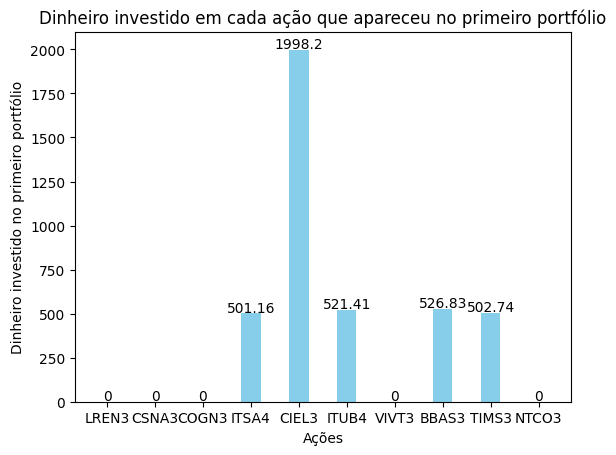

In [ ]:
a = []
b = []
rend = []
x = []
capital_not = [] #capital nao utilizado
[aux,temp,porcentagem,d,c] = info_model(all_models[0],actions,s[0]) #c é variavel auxiliar
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0] #Ver capital
total = [0,0,0,0,0,0,0,0,0,0]

for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='skyblue',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no primeiro portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no primeiro portfólio")
plt.show()

O tempo foi:  0.037849 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  44.23
Capital final:  10044.23
Rendimento da carteira:  0.004422711203571078 %
Dinheiro total investido nas ações:  4420.06
Dinheiro não investido:  5579.94
Quantidade de dinheiro investida em cada ação:  {'ITSA4': 505.92, 'CIEL3': 1998.63, 'VIVT3': 519.61, 'BBAS3': 885.6, 'TIMS3': 510.3}
Número de ações compradas:  {'ITSA4': 68, 'CIEL3': 419, 'VIVT3': 13, 'BBAS3': 24, 'TIMS3': 45}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, -0.0, 225.37948179704784, -0.0, 523.6318529613761, -0.0, -0.0]
z(variável binária) = [0, 0, 0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 0]


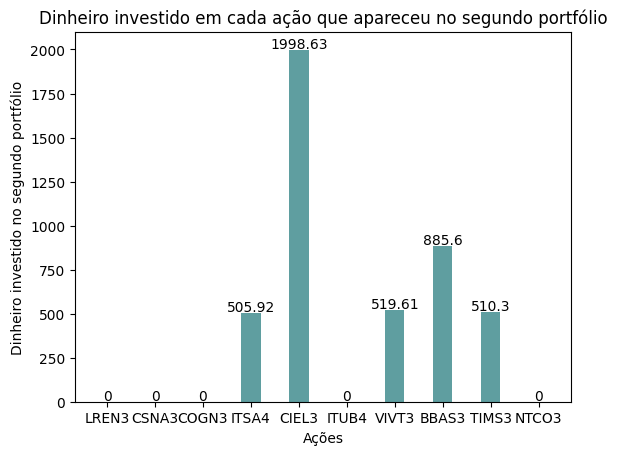

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[1],actions,s[1])
x.append(d)
a.append(aux)
b.append(temp)
rend.append(porcentagem)
capital_not.append(c)


quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='cadetblue',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no segundo portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no segundo portfólio")
plt.show()

O tempo foi:  0.024411 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  8.23
Capital final:  10008.23
Rendimento da carteira:  0.0008225036553441101 %
Dinheiro total investido nas ações:  4209.52
Dinheiro não investido:  5790.48
Quantidade de dinheiro investida em cada ação:  {'CIEL3': 1997.28, 'ITUB4': 517.66, 'VIVT3': 525.84, 'BBAS3': 668.52, 'TIMS3': 500.22}
Número de ações compradas:  {'CIEL3': 438, 'ITUB4': 22, 'VIVT3': 14, 'BBAS3': 18, 'TIMS3': 42}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, 181.30636372493785, 0.0, 481.4327624030178, 0.0, 0.0, 57.80712357587385]
z(variável binária) = [0, 0, 0, 0, 1.0, 0.9999999999999996, 1.0, 1.0, 1.0, 0]


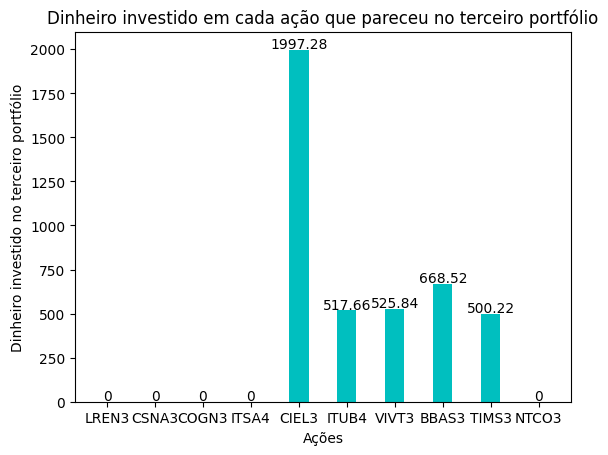

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[2],actions,s[2])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='c',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no terceiro portfólio")
plt.title("Dinheiro investido em cada ação que pareceu no terceiro portfólio")
plt.show()

O tempo foi:  0.018014 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  -29.96
Capital final:  9970.04
Rendimento da carteira:  -0.0029963821201290344 %
Dinheiro total investido nas ações:  4040.81
Dinheiro não investido:  5959.19
Quantidade de dinheiro investida em cada ação:  {'ITSA4': 505.4, 'CIEL3': 1997.09, 'VIVT3': 518.14, 'BBAS3': 509.88, 'TIMS3': 510.3}
Número de ações compradas:  {'ITSA4': 70, 'CIEL3': 437, 'VIVT3': 14, 'BBAS3': 14, 'TIMS3': 42}

Resto das variáveis: 

y(semi desvio padrão) = [115.9236939059581, 0.0, 394.0863832633839, 0.0, 0.0, 5.927409298833865, 0.0]
z(variável binária) = [0, 0, 0, 0.999999999999996, 1.0, 0, 1.0, 1.0, 1.0, 0]


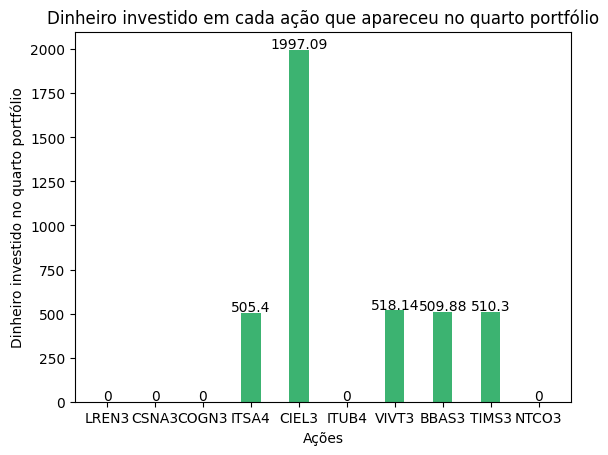

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[3],actions,s[3])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='mediumseagreen',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no quarto portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no quarto portfólio")
plt.show()

O tempo foi:  0.021144 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  12.95
Capital final:  10012.95
Rendimento da carteira:  0.0012954583757285888 %
Dinheiro total investido nas ações:  6986.52
Dinheiro não investido:  3013.48
Quantidade de dinheiro investida em cada ação:  {'ITSA4': 505.56, 'CIEL3': 1996.8, 'ITUB4': 507.78, 'BBAS3': 1986.0, 'TIMS3': 1990.38}
Número de ações compradas:  {'ITSA4': 66, 'CIEL3': 384, 'ITUB4': 21, 'BBAS3': 50, 'TIMS3': 147}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, 857.8092722518855, 0.0, 0.0, 28.68809008629141, 0.0, 860.86293419563]
z(variável binária) = [0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0]


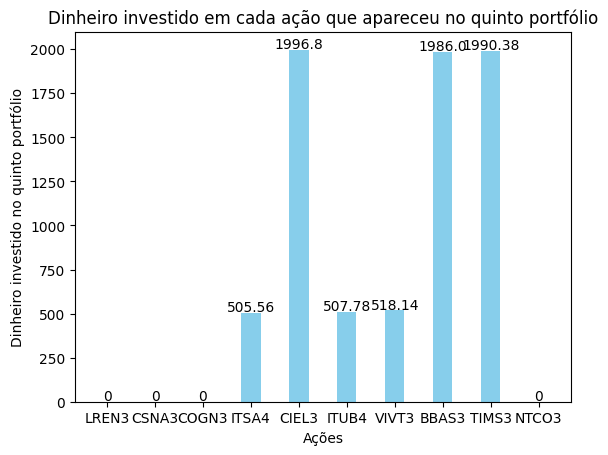

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[4],actions,s[4])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='skyblue',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no quinto portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no quinto portfólio")
plt.show()

In [ ]:
def addlabelss(x,y): #funcao especifica para o grafico com valores pequenos
  for i in range(len(x)):
      plt.text(i, y[i] + 0.2, round(y[i],2), ha = 'center')

O tempo foi:  0.024463 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  -28.67
Capital final:  9971.33
Rendimento da carteira:  -0.0028672323366343883 %
Dinheiro total investido nas ações:  3281.28
Dinheiro não investido:  6718.72
Quantidade de dinheiro investida em cada ação:  {'ITSA4': 505.7, 'CIEL3': 503.98, 'ITUB4': 522.69, 'BBAS3': 1248.3, 'TIMS3': 500.61}
Número de ações compradas:  {'ITSA4': 65, 'CIEL3': 113, 'ITUB4': 21, 'BBAS3': 30, 'TIMS3': 37}

Resto das variáveis: 

y(semi desvio padrão) = [406.36735114952637, 0.0, 0.0, 0.0, 0.0, 357.2348237245188, 72.31604680882516]
z(variável binária) = [0, 0, 0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0]


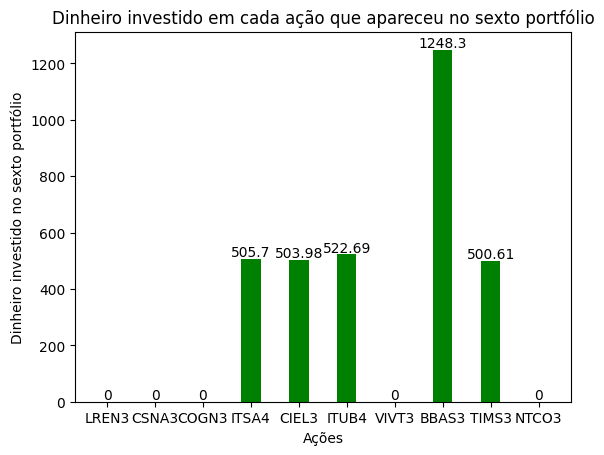

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[5],actions,s[5])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='green',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no sexto portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no sexto portfólio")
plt.show()

O tempo foi:  0.077724 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  103.31
Capital final:  10103.31
Rendimento da carteira:  0.010330528764772655 %
Dinheiro total investido nas ações:  9981.12
Dinheiro não investido:  18.88
Quantidade de dinheiro investida em cada ação:  {'CSNA3': 1992.15, 'COGN3': 688.8, 'ITSA4': 1991.8, 'CIEL3': 503.88, 'ITUB4': 839.17, 'BBAS3': 1974.84, 'TIMS3': 1990.48}
Número de ações compradas:  {'CSNA3': 171, 'COGN3': 210, 'ITSA4': 230, 'CIEL3': 114, 'ITUB4': 31, 'BBAS3': 42, 'TIMS3': 139}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, 0.0, 0.0, 0.0, 554.4429001447977, 339.8650356247022, 0.0]
z(variável binária) = [0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 0]


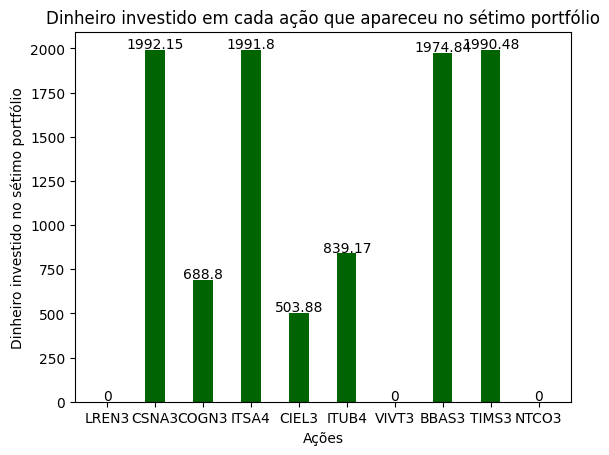

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[6],actions,s[6])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='darkgreen',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido no sétimo portfólio")
plt.title("Dinheiro investido em cada ação que apareceu no sétimo portfólio")
plt.show()

O tempo foi:  0.07761799999999999 segundos
Epsilon usado pelo SCIP para poder transformar em zero:  1e-09

Os resultados que envolvem capital serão arredondados até centésimos e os que envolvem cotas serão números inteiros somente: 

Valor ótimo encontrado:  97.73
Capital final:  10097.73
Rendimento da carteira:  0.009772686378425387 %
Dinheiro total investido nas ações:  9944.66
Dinheiro não investido:  55.34
Quantidade de dinheiro investida em cada ação:  {'CSNA3': 1999.71, 'ITSA4': 1997.28, 'ITUB4': 1344.5, 'BBAS3': 1955.21, 'TIMS3': 1997.8, 'NTCO3': 650.16}
Número de ações compradas:  {'CSNA3': 153, 'ITSA4': 228, 'ITUB4': 50, 'BBAS3': 43, 'TIMS3': 140, 'NTCO3': 36}

Resto das variáveis: 

y(semi desvio padrão) = [0.0, 0.0, 33.54603799014535, 438.53550222364765, 339.7064229040007, -0.0, 288.15665518927]
z(variável binária) = [0, 1.0, 0, 1.0, 0, 1.0, 0, 1.0, 1.0, 1.0]


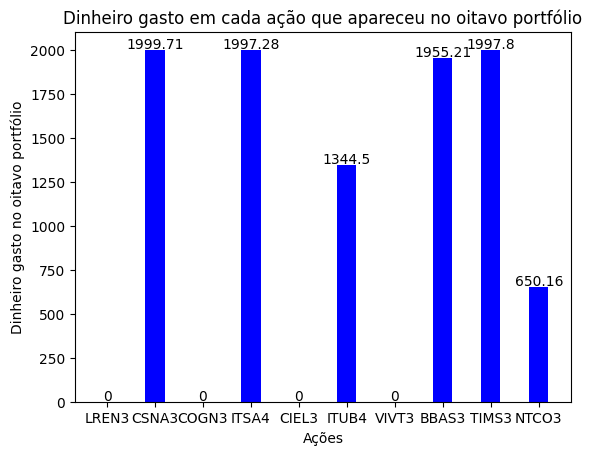

In [ ]:
[aux,temp,porcentagem,d,c] = info_model(all_models[7],actions,s[7])
a.append(aux)
b.append(temp)
rend.append(porcentagem)
x.append(d)
capital_not.append(c)

quantas_acoes = [0,0,0,0,0,0,0,0,0,0]
for i in temp:
    quantas_acoes[i] = aux[i]
    total[i] = total[i] + quantas_acoes[i]
plt.bar(actions, quantas_acoes, color ='blue',
        width = 0.4)

addlabels(actions,quantas_acoes)

plt.xlabel("Ações")
plt.ylabel("Dinheiro gasto no oitavo portfólio")
plt.title("Dinheiro gasto em cada ação que apareceu no oitavo portfólio")
plt.show()

In [ ]:
count = [0,0,0,0,0,0,0,0,0,0]
for i in b:
  for j in i:
    count[j] = count[j] + 1
print(count)

[0, 2, 1, 7, 7, 6, 3, 8, 8, 1]


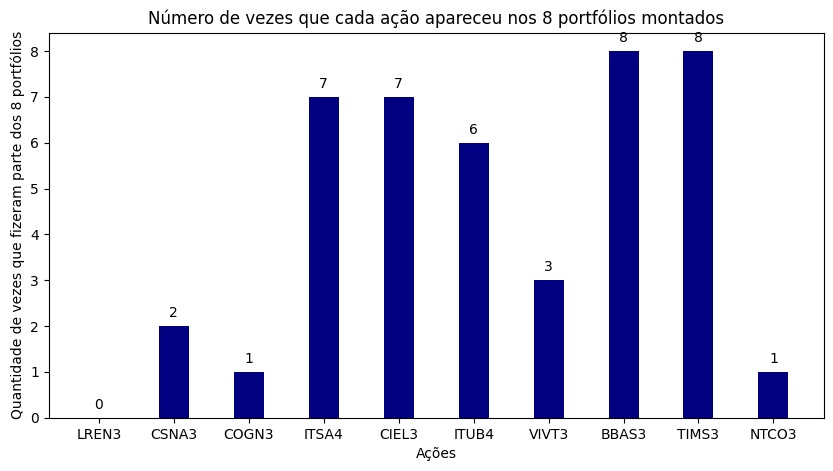

In [ ]:
fig = plt.figure(figsize = (10, 5))

plt.bar(actions, count, color ='navy',
        width = 0.4)

addlabelss(actions,count)

plt.xlabel("Ações")
plt.ylabel("Quantidade de vezes que fizeram parte dos 8 portfólios")
plt.title("Número de vezes que cada ação apareceu nos 8 portfólios montados")
plt.show()

In [1]:
def addlabelsss(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 100, round(y[i],2), ha = 'center')

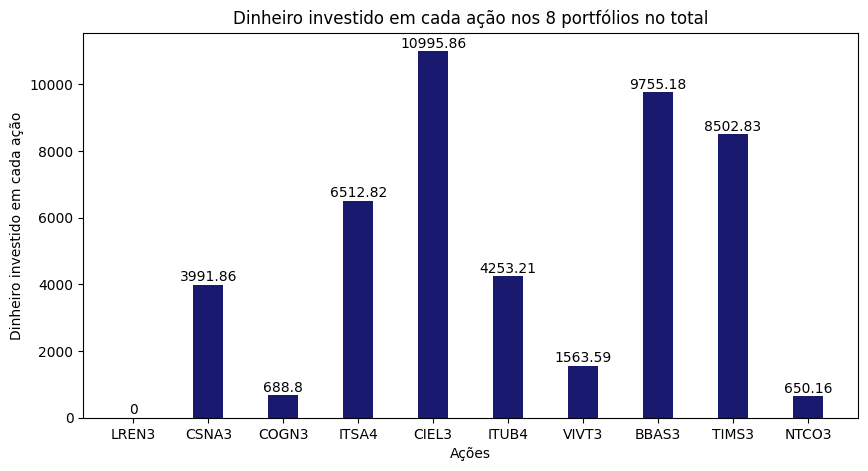

In [ ]:
figg = plt.figure(figsize = (10, 5))

plt.bar(actions, total, color ='midnightblue',
        width = 0.4)

addlabelsss(actions,total)

plt.xlabel("Ações")
plt.ylabel("Dinheiro investido em cada ação")
plt.title("Dinheiro investido em cada ação nos 8 portfólios no total")
plt.show()

Rendimentos em %: [0.00506258192340768, 0.004422711203571078, 0.0008225036553441101, -0.0029963821201290344, 0.0012954583757285888, -0.0028672323366343883, 0.010330528764772655, 0.009772686378425387]


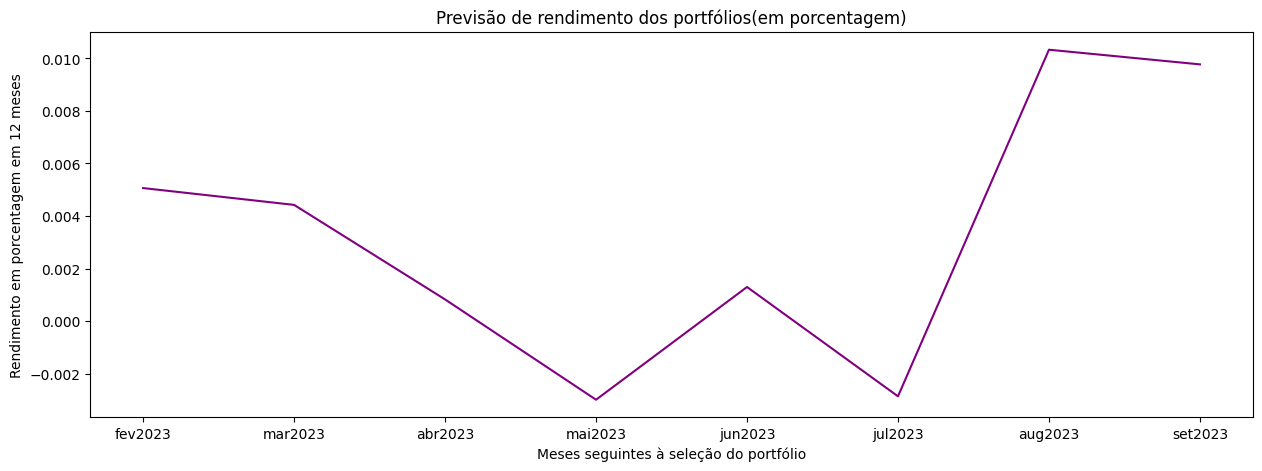

In [ ]:
meses = ['fev2023','mar2023','abr2023','mai2023','jun2023','jul2023','aug2023','set2023']
print('Rendimentos em %:',rend)

figgg = plt.figure(figsize = (15, 5))

plt.plot(meses,rend,color='purple')

plt.xlabel("Meses seguintes à seleção do portfólio")
plt.ylabel("Rendimento em porcentagem em 12 meses")
plt.title("Previsão de rendimento dos portfólios(em porcentagem)")
plt.show()

In [ ]:
for i in x:
  print(i)

[0, 0, 0, 68, 412, 23, 0, 17, 42, 0]
[0, 0, 0, 68, 419, 0, 13, 24, 45, 0]
[0, 0, 0, 0, 438, 22, 14, 18, 42, 0]
[0, 0, 0, 70, 437, 0, 14, 14, 42, 0]
[0, 0, 0, 66, 384, 21, 0, 50, 147, 0]
[0, 0, 0, 65, 113, 21, 0, 30, 37, 0]
[0, 171, 210, 230, 114, 31, 0, 42, 139, 0]
[0, 153, 0, 228, 0, 50, 0, 43, 140, 36]


Rendimentos reais(serão usados para comparar com os previstos pelo modelo): 
Rendimentos em %: [0.006237000000000048, -0.010354999999999892, -0.0014120000000000799, 0.04525499999999982, -0.0168299999999999, 0.028998999999999997, 0.021237000000000172, -0.04569100000000004]


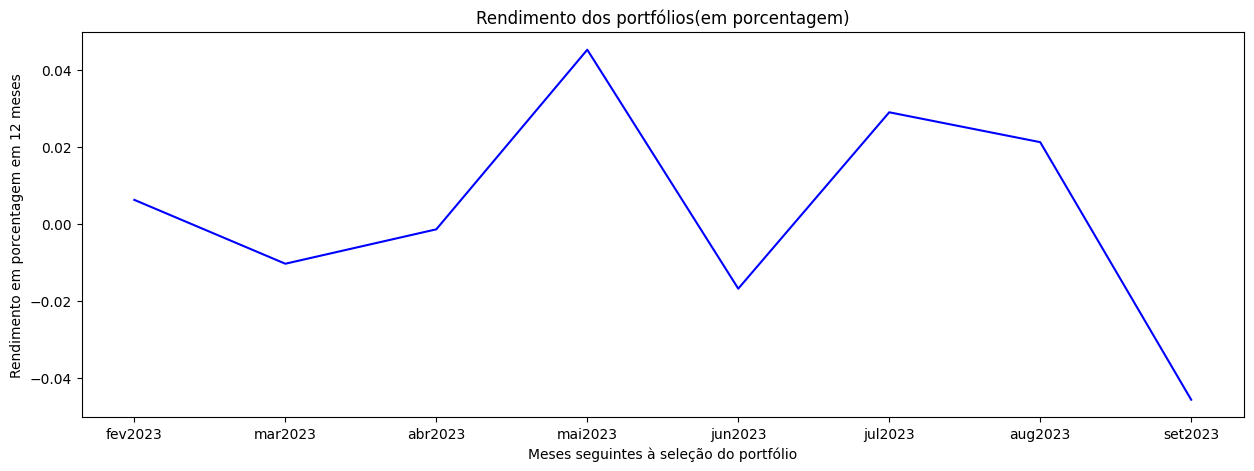

In [ ]:
# Pegando dados futuros(set-2023) para ver como o rendimento foi realmente

mes_nove = [15.73, 11.74, 2.95, 8.33, 3.65, 26.09, 40.97, 45.49, 14.17, 15.22]

s.append(mes_nove)

rend_real = []

for i in range(len(x)):
  auxx = []
  for j in range(len(x[i])):
    auxx.append(s[i+1][j]*x[i][j])
  rend_real.append(round(sum(auxx),2))

total = []

for i in range(len(rend_real)):
  total.append(round(rend_real[i] + capital_not[i],2))

print("Rendimentos reais(serão usados para comparar com os previstos pelo modelo): ")

porcent = []

for j in range(len(rend_real)):
  porcent.append(total[j]/C - 1)

print('Rendimentos em %:',porcent)

meses = ['fev2023','mar2023','abr2023','mai2023','jun2023','jul2023','aug2023','set2023']

figgg = plt.figure(figsize = (15, 5))

plt.plot(meses,porcent,color='blue')

plt.xlabel("Meses seguintes à seleção do portfólio")
plt.ylabel("Rendimento em porcentagem em 12 meses")
plt.title("Rendimento dos portfólios(em porcentagem)")
plt.show()

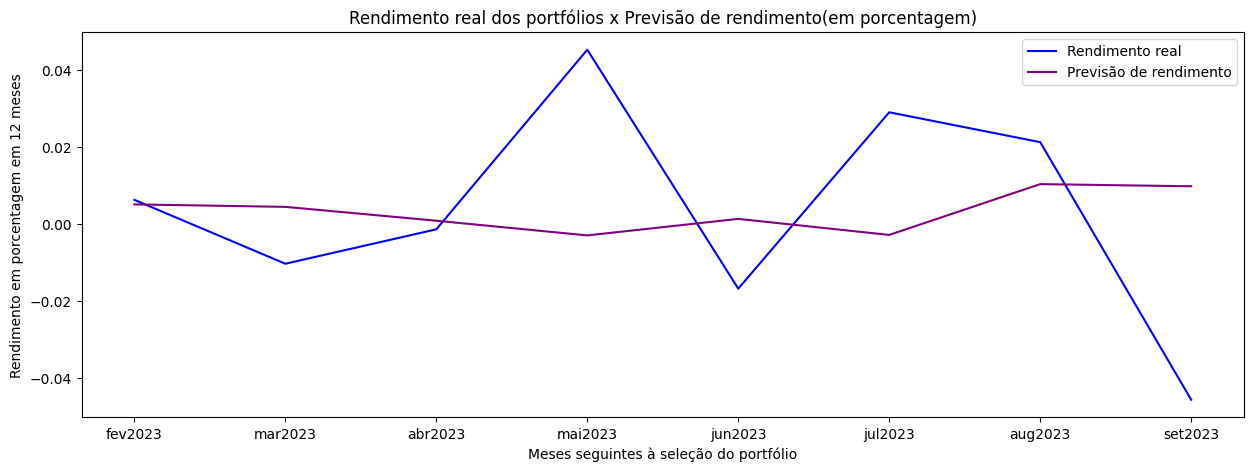

In [ ]:
figgg = plt.figure(figsize = (15, 5))

plt.plot(meses,porcent,color='blue',label='Rendimento real')
plt.plot(meses,rend,color='purple',label='Previsão de rendimento')

plt.xlabel("Meses seguintes à seleção do portfólio")
plt.ylabel("Rendimento em porcentagem em 12 meses")
plt.title("Rendimento real dos portfólios x Previsão de rendimento(em porcentagem)")
plt.legend()
plt.show()